<a href="https://colab.research.google.com/github/dani-lbnl/2022_als_user_meeting/blob/main/05_multiscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALS User Meeting 2022
This notebook describes methods to extract key information from microCT image stacks
- Downscale: subsampling vs. downsampling
- Multiscale pyramid
- Morphological operators

Created by Dani Ushizima, CAMERA, LBNL - Aug 1st 2022


In [1]:
%matplotlib inline

In [26]:
import numpy as np
from scipy import ndimage as ndi
import fnmatch,os
import matplotlib.pyplot as plt
from glob import glob

from skimage import img_as_ubyte, filters, morphology, exposure, io
from skimage.filters import threshold_isodata
from skimage.transform import pyramid_expand, pyramid_reduce, pyramid_gaussian
from skimage.measure import regionprops,label


# 1. Read a microct image
- from url
- from NERSC
- from Google drive

## Read from NERSC
- discard this portion if running in Colab

In [3]:
datapath = "/global/cfs/cdirs/als/users/yourname/yourdata/" #update these values
!ls -lt "$datapath"

ls: cannot access '/global/cfs/cdirs/als/users/yourname/yourdata/': No such file or directory


In [ ]:
image = io.imread(datapath+'bead_pack.tif')

## Read from Google drive 
- discard this portion if running at NERSC

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
datapath = "/content/drive/My Drive/Colab Notebooks/ALS User Meeting 2022 colab/data/"
!ls -lt "$datapath"

total 7842
-rw------- 1 root root 8025493 Aug 11 16:46 bead_pack.tif
drwx------ 2 root root    4096 Aug 11 16:35 concrete


In [6]:
def loadFileNames(path,extension):
  ''' Return filename after using colab files.upload - work for 1 file'''
  fnames = glob(path+extension)
  fnames.sort()
  print(path);
  print(f"Number of files: {len(fnames)}")
  return fnames

In [7]:
files = loadFileNames(datapath+'concrete/','*tif')

/content/drive/My Drive/Colab Notebooks/ALS User Meeting 2022 colab/data/concrete/
Number of files: 20


# 2. Subsampling
- Get smaller portion of an original sample, created by trimming, subdividing, splitting or discrete collection of the original sample
- Slicing numpy array using indexing tricks


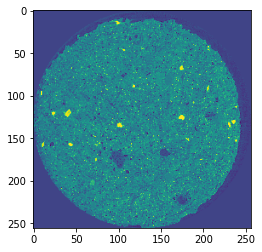

In [18]:
n = 5
aslice = io.imread(files[n])
subsamp = 10
aSmallerSlice1 = aslice[::subsamp,::subsamp]
plt.imshow(aSmallerSlice1) #throw away every other *subsamp* row and column 

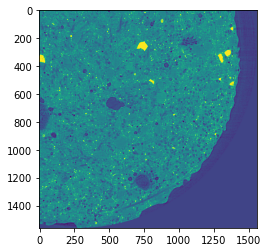

In [19]:
# Slice items starting from index 
plt.imshow(aslice[1000:,1000:])

# 3. Downsampling
- Reduce the sampling rate of (a signal) 
- Often associated to a strategy on combining pixel/voxel values during downscaling, e.g., average


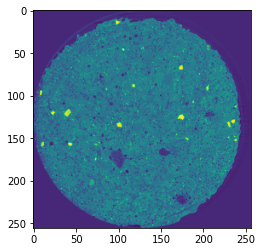

In [20]:
aSmallerSlice2 = pyramid_reduce(aslice,downscale=10)
plt.imshow(aSmallerSlice2)

In [21]:
def imshowcmp(before,after,lut='plasma'):
    '''Show 2 images side by side'''
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(before,cmap=lut)
    ax[1].imshow(after,cmap=lut)

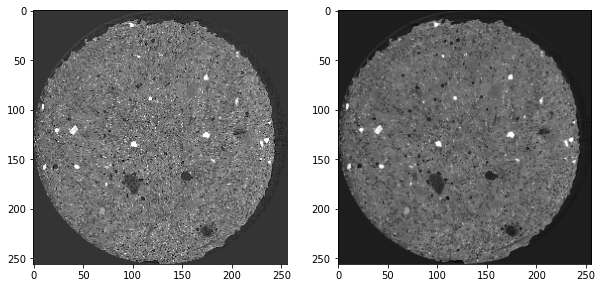

In [22]:
imshowcmp(aSmallerSlice1,aSmallerSlice2,'gray')

# 4. Image pyramids
- yields successive images shrunk by a constant scale factor. Image pyramids are often used, e.g., to implement algorithms for denoising, texture discrimination, and scale-invariant detection
- other examples [here](https://scikit-image.org/docs/stable/auto_examples/transform/plot_pyramid.html#sphx-glr-auto-examples-transform-plot-pyramid-py)


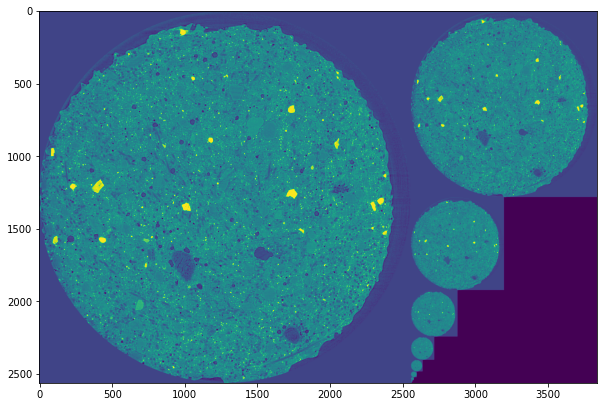

In [34]:
rows, cols = aslice.shape
pyramid = tuple(pyramid_gaussian(aslice, downscale=2))

composite_image = np.zeros((rows, cols + cols // 2), dtype=np.double)

composite_image[:rows, :cols] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(composite_image)